# Contents
1. [Data Cleaning (Weather)](#1.-Data-Cleaning-(Weather))
2. [Data Cleaning (Power Outages)](#2.-Data-Cleaning-(Power-Outages))
3. [Data Cleaning: Merge of Weather Data and Power Outage Labels](#3.-Merge-of-Weather-Data-and-Power-Outage-Labels)
4. [Exploratory Analysis](#4.-Exploratory-Analysis)
5. [Mapping Outages to Weather](#5.-Mapping-Outages-to-Weather)

In [1]:
# Load libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pytemperature

# Python magic to display matplolib plots in the notebook.
%matplotlib inline

## 1. Data Cleaning (Weather)

#### Loading weather data downloaded from [Kaggle's Historic Hourly Weather](https://www.kaggle.com/selfishgene/historical-hourly-weather-data).

In [2]:
# Load weather data from multiple CSV files.
humidity = pd.read_csv('data/kaggle_weather_datasets/humidity.csv')
pressure = pd.read_csv('data/kaggle_weather_datasets/pressure.csv')
temperature = pd.read_csv('data/kaggle_weather_datasets/temperature.csv')
weather_des = pd.read_csv('data/kaggle_weather_datasets/weather_description.csv')
wind_dir = pd.read_csv('data/kaggle_weather_datasets/wind_direction.csv')
wind_speed = pd.read_csv('data/kaggle_weather_datasets/wind_speed.csv')

In [3]:
# Check format of datasets. 
temperature.head(2)

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,309.10,NaN,NaN,NaN
1,2012-10-01 13:00:00,284.63,282.08,289.48,281.8,291.87,291.53,293.41,296.6,285.12,...,285.63,288.22,285.83,287.17,307.59,305.47,310.58,304.4,304.4,303.5


#### Merging weather datasets.

In [4]:
# Merge datasets, keeping only New York weather information.

df_list = [pressure, temperature, weather_des, wind_dir, wind_speed]
df_names = ['pressure', 'temperature', 'weather_des', 'wind_dir', 'wind_speed']

## Create "merged_df" variable with humidity dataset.
merged_df = humidity[['datetime', 'New York']].rename(columns = {'New York' : 'ny_humidity'})

## For loop to add remaining datasets to "merged_df".
df_counter = 0
for df in df_list:
    df_name = df_names[df_counter]
    new_df = df[['datetime', 'New York']].rename(columns = {'New York' : 'ny_' + df_name})
    merged_df = merged_df.merge(new_df, how = 'right', on = 'datetime')
    df_counter += 1
    
## Check shape of merged dataframes.
print('Merged dataset has {} rows and {} columns.'.format(merged_df.shape[0], merged_df.shape[1]))
## Check "merged_df"
merged_df.head()

Merged dataset has 45253 rows and 7 columns.


,datetime,ny_humidity,ny_pressure,ny_temperature,ny_weather_des,ny_wind_dir,ny_wind_speed
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-10-01 13:00:00,58.0,1012.0,288.220000,few clouds,260.0,7.0
2,2012-10-01 14:00:00,57.0,1012.0,288.247676,few clouds,260.0,7.0
3,2012-10-01 15:00:00,57.0,1012.0,288.326940,few clouds,260.0,7.0
4,2012-10-01 16:00:00,57.0,1012.0,288.406203,few clouds,260.0,7.0


#### Changing format, datatypes, dropping nulls,  and re-setting index.

In [5]:
# Change datatype of "datetime" column from object to datetime.
merged_df['datetime'] = pd.to_datetime(merged_df['datetime'])

In [6]:
# Dropped humidity and pressure data, due to assumption that there is no strong correlation between these and power outages.
merged_df = merged_df.drop(columns = ['ny_humidity', 'ny_pressure'])

In [7]:
# Drop null values by indexing. Null values are located only at beginning of dataframe and end of dataframe.
# This allows for no gaps in between 10/1/2012 2 PM - 10/28/2017 12 AM.

merged_df = merged_df.iloc[1:44461]

In [8]:
# Set "datetime" column as index
merged_df = merged_df.set_index('datetime').sort_index()

In [9]:
# Change temperature data from Kelvin to Fahrenheit.
# https://pypi.org/project/pytemperature/
merged_df['ny_temperature'] = pytemperature.k2f(merged_df['ny_temperature'])

In [10]:
# Function to convert meters per second to miles per hour.
def convert_mph(meters_ps):
    miles = meters_ps / 1609.344
    miles_ph = miles * 3600
    
    return int(miles_ph)

# Convert "ny_wind_speed" (wind speed) from meters per second to miles per hour. 
merged_df.ny_wind_speed = merged_df.ny_wind_speed.map(lambda cell: convert_mph(cell))

In [11]:
# Rename columns to reflect units.
merged_df.rename(columns = {
    'ny_temperature' : 'temperature_f',
    'ny_wind_dir'    : 'wind_dir_degrees',
    'ny_wind_speed'  : 'wind_speed_mph'
}, inplace = True)

# Change format of column names; spaces replaced by underscores.
column_new_names = []
for column in merged_df.columns:
    new_name = column.replace(' ', '_')
    column_new_names.append(new_name)
merged_df.columns = column_new_names

#### Creating dummy variables for wind descriptions.

In [12]:
# Create dummy features for text values in "ny_weather_des" (weather descriptions).

## Check how many unique values for weather descriptions.
print('{} unique weather description values.'.format(merged_df.ny_weather_des.nunique()))

## Create dummy variables. 
dummy_variables = pd.get_dummies(merged_df['ny_weather_des'])

## Merge dummy variables with merged_df that holds other weather features.
merged_df = merged_df.merge(dummy_variables, on = 'datetime')

## Drop text/object dtype column "ny_weather_des" (weather descriptions).
merged_df.drop(columns ='ny_weather_des', inplace = True)

36 unique weather description values.


#### Final cleaned weather dataframe.

In [13]:
# Check shape of cleaned weather data.
print('Merged dataset has {} rows and {} columns.'.format(merged_df.shape[0], merged_df.shape[1]))
#  Check "merged_df".
merged_df.head(3)

Merged dataset has 44460 rows and 39 columns.


,temperature_f,wind_dir_degrees,wind_speed_mph,broken clouds,drizzle,dust,few clouds,fog,freezing rain,haze,...,sky is clear,smoke,snow,squalls,thunderstorm,thunderstorm with heavy rain,thunderstorm with light drizzle,thunderstorm with light rain,thunderstorm with rain,very heavy rain
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01 13:00:00,59.11,260.0,15,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-10-01 14:00:00,59.16,260.0,15,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-10-01 15:00:00,59.30,260.0,15,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2. Data Cleaning (Power Outages)

#### Loading power outage data downloaded from [NYC OpenData's OEM Emergency Notifications](https://data.cityofnewyork.us/Public-Safety/OEM-Emergency-Notifications/8vv7-7wx3/data).

In [14]:
# Load outage data from multiple CSV files.
open_nyc = pd.read_csv('./data/nyc_open_datasets/OEM_Emergency_Notifications.csv')
non_outage = pd.read_csv('./data/nyc_open_datasets/OEM_Non_Outages.csv')

In [15]:
# Check format of datasets.
open_nyc.head(2)

,Record ID,Date and Time,NotificationType,Notification Title,Email Body
0,11993,12/27/2018 01:42:00 PM,Utility,Con Edison Power Outage - Gravesend (BK),Notification issued 12-27-2018 at 1:42 PM. Con...
1,11948,12/21/2018 03:20:00 PM,Utility,Power Outage - Breezy Point & Roxbury (QN),Notification issued 12-21-2018 at 3:20 PM. PSE...


In [16]:
non_outage.head(2)

,Record ID,Date and Time,NotificationType,Notification Title,Email Body
0,9601,10/28/2017 10:22:00 PM,Road Closure,Traffic Delays - FDR Drive at 34th Street (MN),Notification issued 10/28/17 at 10:22 PM. Due ...
1,9600,10/28/2017 03:30:00 PM,Weather,High Wind Watch - 10/29-10/30 (CW),Notification issued 10/28/17 at 3:30 PM. The N...


In [17]:
# Check shape of "open_nyc" and "non_outage" dataframes.
print('open_nyc dataset has {} rows and {} columns.'.format(open_nyc.shape[0], open_nyc.shape[1]))
print('non_outages dataset has {} rows and {} columns.'.format(non_outage.shape[0], non_outage.shape[1]))

open_nyc dataset has 579 rows and 5 columns.
non_outages dataset has 6721 rows and 5 columns.


#### Creating new label / "outage" column .

In [18]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.insert.html
open_nyc.insert(5, 'outage', 1)
non_outage.insert(5, 'outage', 0)

#### Merge power outage and non-outage notifications dataframes.

In [19]:
merged_outage = pd.concat([open_nyc, non_outage])

# Check head and shape of "merged_outage" dataframe. 
print('merged_outage dataset has {} rows and {} columns.'.format(merged_outage.shape[0], merged_outage.shape[1]))
merged_outage.head(2)

merged_outage dataset has 7300 rows and 6 columns.


,Record ID,Date and Time,NotificationType,Notification Title,Email Body,outage
0,11993,12/27/2018 01:42:00 PM,Utility,Con Edison Power Outage - Gravesend (BK),Notification issued 12-27-2018 at 1:42 PM. Con...,1
1,11948,12/21/2018 03:20:00 PM,Utility,Power Outage - Breezy Point & Roxbury (QN),Notification issued 12-21-2018 at 3:20 PM. PSE...,1


In [20]:
# Check tail of "merged_outage".
merged_outage.tail(2)

,Record ID,Date and Time,NotificationType,Notification Title,Email Body,outage
6719,2440,10/02/2012 03:39:00 AM,Road Closure,All Lanes Re-opened - Whitestone Bridge,Notification issued 10/2/2012 at 3:39 AM. Afte...,0
6720,2439,10/02/2012 12:07:00 AM,Road Closure,All Lanes Closed - Whitestone Bridge,Notification issued 10/2/2012 at 12:07 AM. Due...,0


#### Dropping unecessary columns, formatting name of columns, changing datatypes, dropping duplicates and re-setting index.

In [21]:
# Drop unecessary columns. 
merged_outage.drop(columns = ['Record ID', 'Notification Title', 'Email Body'], inplace = True)

In [22]:
# Lowercase column names.
new_cols = []
for column in merged_outage.columns:
    new_cols.append(column.lower())
new_cols

merged_outage.columns = new_cols

In [23]:
# Replace spaces in column names with underscores.
column_new_names = []
for column in merged_outage.columns:
    new_name = column.replace(' ', '_')
    column_new_names.append(new_name)

merged_outage.columns = column_new_names

In [24]:
# Rename column names, including "date_and_time" to be same as "datetime" column in weather dataframe.
merged_outage.rename(columns={'notificationtype': 'notification_type', 'date_and_time': 'datetime'}, inplace=True)

In [25]:
# Change datatype of "datetime" column from object to datetime.
merged_outage.datetime = pd.to_datetime(merged_outage.datetime)

In [26]:
# Drop minute and second data from "merged_outage" dataframe, to match format of weather dataframe. 
merged_outage.datetime = merged_outage.datetime.map(lambda x: x.replace(minute=0, second=0))

In [27]:
# Check for duplicate rows.
print('There are {} duplicate rows in original merged_outage dataframe.'.format(merged_outage.duplicated('datetime').sum()))

# Drop duplicate rows.
merged_outage = merged_outage.drop_duplicates('datetime')

# Re-check for duplicate rows.
print('After drop duplicated method, {} confirmed duplicate rows.'.format(merged_outage.duplicated('datetime').sum()))

There are 936 duplicate rows in original merged_outage dataframe.
After drop duplicated method, 0 confirmed duplicate rows.


In [28]:
# Set "datetime" as index.
merged_outage = merged_outage.set_index('datetime').sort_index()

#### Creating dummy variables for notification_type.

In [29]:
# Create dummy features for text values in "notification_type" (weather descriptions).

## Check how many unique values for weather descriptions.
print('{} unique notification types.'.format(merged_outage.notification_type.nunique()))

## Create dummy variables. 
dummy_variables = pd.get_dummies(merged_outage['notification_type'])

## Merge dummy variables with merged_outage that holds other weather features.
merged_outage = dummy_variables.merge(merged_outage, on = 'datetime')

## Drop text/object dtype column "notification_type" (weather descriptions).
merged_outage.drop(columns ='notification_type', inplace = True)

17 unique notification types.


#### Final clean power outages dataframe. 

In [30]:
# Check tail and shape of "merged_outage" dataframe. 
print('merged_outage dataset has {} rows and {} columns.'.format(merged_outage.shape[0], merged_outage.shape[1]))
merged_outage.tail(2)

merged_outage dataset has 6364 rows and 18 columns.


,Aerial (Fly-Over),Drills / Exercises,Environmental,Fire,Infrastructure,Mass Transit Disruption,Mass Transit Restoration,Missing Adult,Missing Child / Adolescent,Parking,Public Awareness,Public Health,Road Closure,School Notification,Structural,Utility,Weather,outage
datetime,,,,,,,,,,,,,,,,,,
2018-12-21 15:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2018-12-27 13:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


## 3. Merge of Weather Data and Power Outage Labels

In [31]:
# Checking sizes of both dataframes ("merged_df"/weather dataframe and "merged_outage"/power outage dataframe.)
print('There are {} row and {} columns in weather dataframe.'.format(merged_df.shape[0], merged_df.shape[1]))
print('There are {} row and {} columns in power outage label dataframe.'.format(merged_outage[['outage']].shape[0], merged_outage[['outage']].shape[1]))

There are 44460 row and 39 columns in weather dataframe.
There are 6364 row and 1 columns in power outage label dataframe.


In [32]:
# Merge of 2 dataframes. 

weather_outage_merge = pd.merge(merged_df, merged_outage[['outage']], on ='datetime', how = 'left')
weather_outage_merge.head(2)

,temperature_f,wind_dir_degrees,wind_speed_mph,broken clouds,drizzle,dust,few clouds,fog,freezing rain,haze,...,smoke,snow,squalls,thunderstorm,thunderstorm with heavy rain,thunderstorm with light drizzle,thunderstorm with light rain,thunderstorm with rain,very heavy rain,outage
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01 13:00:00,59.11,260.0,15,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2012-10-01 14:00:00,59.16,260.0,15,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


#### Imputing null values with label 0 (no outage). 

In [33]:
# Filling null values in "outage" column with 0s, corresponding to no outage label. 
weather_outage_merge.fillna(value=0, inplace = True)

#### Final clean weather and power outage labels dataframe. 

In [34]:
# Checking size and head of new merged dataframe. 
print('There are {} row and {} columns in merged weather and power outage dataframe.'.format(weather_outage_merge.shape[0], weather_outage_merge.shape[1]))
weather_outage_merge.head(2)

There are 44460 row and 40 columns in merged weather and power outage dataframe.


,temperature_f,wind_dir_degrees,wind_speed_mph,broken clouds,drizzle,dust,few clouds,fog,freezing rain,haze,...,smoke,snow,squalls,thunderstorm,thunderstorm with heavy rain,thunderstorm with light drizzle,thunderstorm with light rain,thunderstorm with rain,very heavy rain,outage
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01 13:00:00,59.11,260.0,15,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2012-10-01 14:00:00,59.16,260.0,15,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


#### Saving final working dataframe.

In [35]:
weather_outage_merge.to_csv('./data/weather_and_outage.csv')

# 4. Exploratory Analysis

#### Exploring weather statistics and distributions.

In [36]:
# Statistics for weather data (without dummy variables).
weather_outage_merge.iloc[:, :3].describe()

,temperature_f,wind_dir_degrees,wind_speed_mph
count,44460.000000,44460.000000,44460.000000
mean,54.030706,196.250247,6.674584
std,18.397683,107.433676,4.823533
min,-8.300000,0.000000,0.000000
25%,39.580000,104.000000,4.000000
50%,54.880000,220.000000,6.000000
75%,69.080000,289.000000,8.000000
max,98.740000,360.000000,55.000000


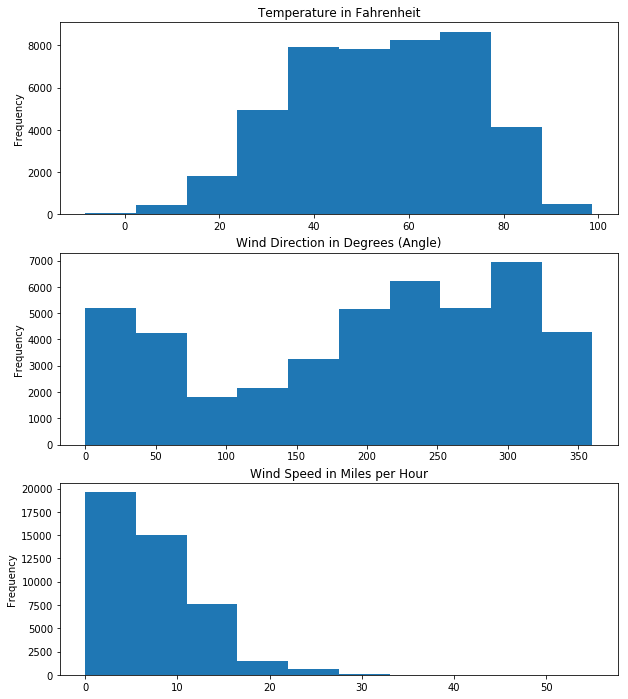

In [37]:
# Distribution subplots of weather data (without dummy variables).
fig, ax = plt.subplots(
    nrows = 3,
    ncols = 1,
    figsize = (10, 12)
    
)

weather_outage_merge['temperature_f'].plot(kind = 'hist', 
                         ax = ax[0], 
                         title = 'Temperature in Fahrenheit'),

weather_outage_merge['wind_dir_degrees'].plot(kind = 'hist', 
                         ax = ax[1], 
                         title = 'Wind Direction in Degrees (Angle)');

weather_outage_merge['wind_speed_mph'].plot(kind = 'hist', 
                         ax = ax[2], 
                         title = 'Wind Speed in Miles per Hour');

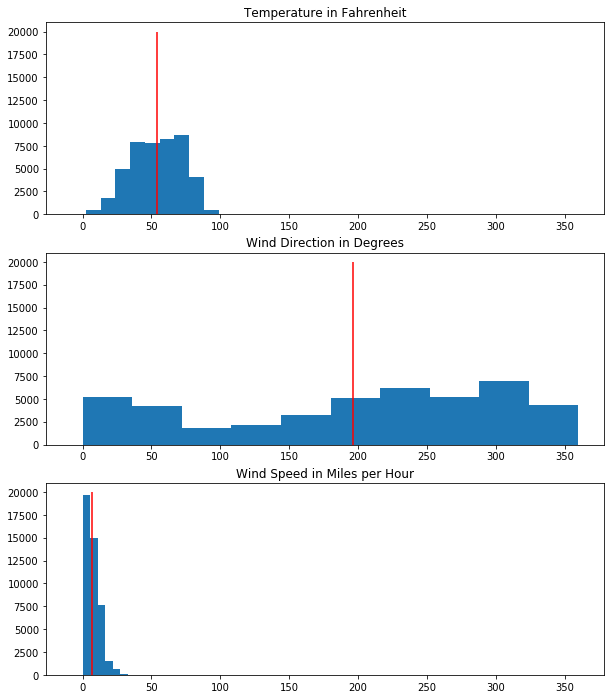

In [38]:
# Comparative subplots of previous distributions.
plt.figure(figsize = (10,12))


ax2 = plt.subplot(312)
ax2.set_title('Wind Direction in Degrees')
ax2.hist([weather_outage_merge['wind_dir_degrees']])
ax2.vlines(x = np.mean(weather_outage_merge['wind_dir_degrees']), 
           ymin = 0, 
           ymax = 20000, 
           color = 'r');

ax3 = plt.subplot(313, sharex = ax2)
ax3.set_title('Wind Speed in Miles per Hour')
ax3.hist([weather_outage_merge['wind_speed_mph']])
ax3.vlines(x = np.mean(weather_outage_merge['wind_speed_mph']), 
           ymin = 0, 
           ymax = 20000, 
           color = 'r');

ax1 = plt.subplot(311, sharex = ax2, sharey = ax3)
ax1.set_title('Temperature in Fahrenheit')
ax1.hist([weather_outage_merge['temperature_f']])
ax1.vlines(x = np.mean(weather_outage_merge['temperature_f']), 
           ymin = 0, 
           ymax = 20000, 
           color = 'r');

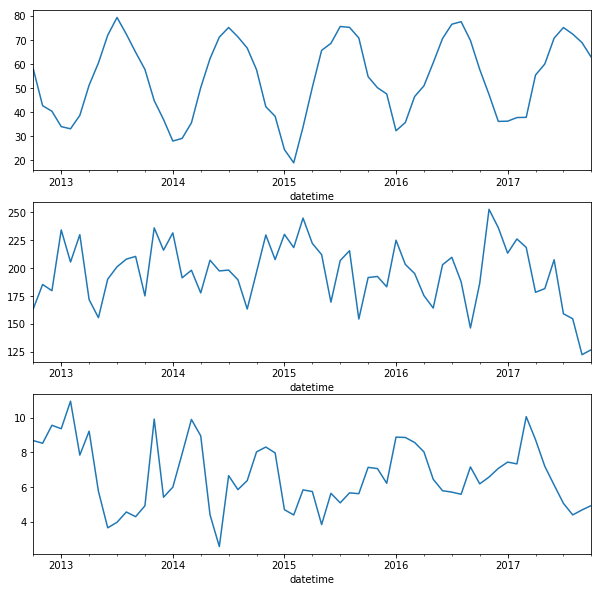

In [39]:
# Weather data changes in span of 5 years 10/2012 - 10/2017.
fig, ax = plt.subplots(
    nrows = 3,
    ncols = 1,
    figsize = (10, 10)
    
)

weather_outage_merge.temperature_f.resample('M').mean().plot(ax = ax[0]);

weather_outage_merge.wind_dir_degrees.resample('M').mean().plot(ax = ax[1]);

weather_outage_merge.wind_speed_mph.resample('M').mean().plot(ax = ax[2]);


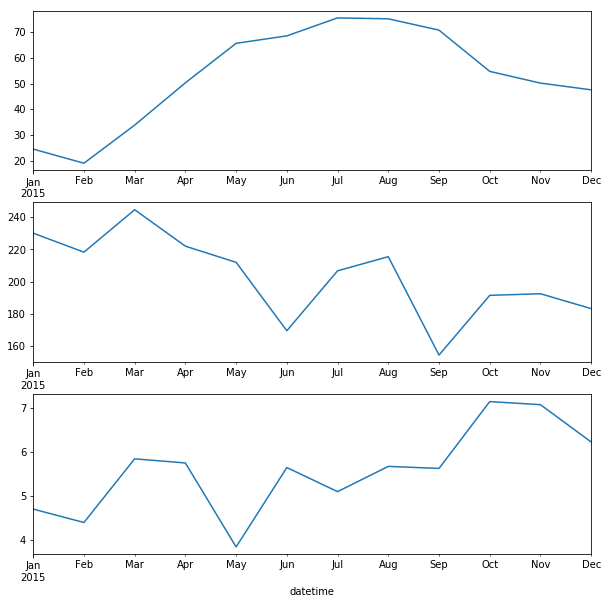

In [40]:
# View of weather changes in time for 2015 only.
fig, ax = plt.subplots(
    nrows = 3,
    ncols = 1,
    figsize = (10, 10)
    
)

weather_outage_merge['2015'].temperature_f.resample('M').mean().plot(ax = ax[0]);

weather_outage_merge['2015'].wind_dir_degrees.resample('M').mean().plot(ax = ax[1]);

weather_outage_merge['2015'].wind_speed_mph.resample('M').mean().plot(ax = ax[2]);

# 5. Mapping Outages to Weather

In [41]:
# Loading final working dataframe with complete "outage" labels to include power outages identified through tweets.

df = pd.read_csv('./data/merged_weather_tweets.csv', index_col = 0)
print('Final working dataframe has {} rows and {} columns.'.format(df.shape[0], df.shape[1]))
df.head(2)

Final working dataframe has 45545 rows and 44 columns.


,datetime,text,regex_clean_tweets,lemmed_tweet,temperature_f,wind_dir_degrees,wind_speed_mph,broken clouds,drizzle,dust,...,smoke,snow,squalls,thunderstorm,thunderstorm with heavy rain,thunderstorm with light drizzle,thunderstorm with light rain,thunderstorm with rain,very heavy rain,outage
0,2012-10-06 13:00:00,Partial power outage at #MediaLoft That's...,Partial power outage MediaLoft That twice week...,Partial power outage MediaLoft That twice week...,61.55,56.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,2012-10-12 01:00:00,"Um, can someone call ConEd , there's a power...",Um someone call ConEd power outage Bronx Sourc...,Um someone call ConEd power outage Bronx Sourc...,59.48,260.0,15,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


#### Minimal data cleaning of final dataframe to use for mapping plots.

In [42]:
# Change "datetime" datatype from object to datetime.
df['datetime'] = pd.to_datetime(df['datetime'])

# Reset index to "datetime".
df.set_index('datetime', inplace = True)
df = df.sort_index()

df.head(2)

,text,regex_clean_tweets,lemmed_tweet,temperature_f,wind_dir_degrees,wind_speed_mph,broken clouds,drizzle,dust,few clouds,...,smoke,snow,squalls,thunderstorm,thunderstorm with heavy rain,thunderstorm with light drizzle,thunderstorm with light rain,thunderstorm with rain,very heavy rain,outage
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01 13:00:00,hello,hello,hello,59.11,260.0,15,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.0
2012-10-01 14:00:00,hello,hello,hello,59.16,260.0,15,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.0


### Viewing weather statistics grouped by outage status.

In [43]:
df[['temperature_f', 'wind_dir_degrees', 'wind_speed_mph', 'outage']].groupby('outage').mean().T

outage,0.0,1.0
temperature_f,53.970204,58.685967
wind_dir_degrees,195.284930,162.395985
wind_speed_mph,6.800764,9.091241


#### Creating subset of dataframe that includes 3 weather features for observations where there were confirmed outages (as per NYC Open Data Notifications).

In [44]:
outages = df[['temperature_f', 'wind_dir_degrees', 'wind_speed_mph', 'outage']][df['outage'] == 1]

# Check "outages" subset. 
outages.head(2)

,temperature_f,wind_dir_degrees,wind_speed_mph,outage
datetime,,,,
2012-10-04 05:00:00,62.65,30.0,4,1.0
2012-10-04 10:00:00,63.08,330.0,4,1.0


#### Mapping Outages to Weather Plots

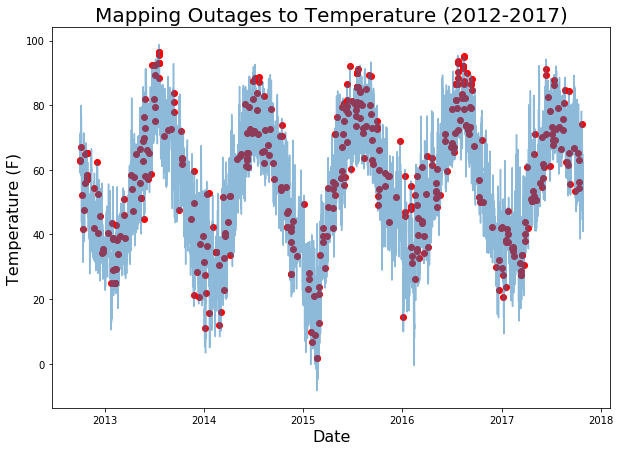

In [45]:
# Mapping Outages to Temperature

plt.figure(figsize=(10, 7))
plt.plot(df.temperature_f, alpha = 0.5)
plt.scatter(outages['temperature_f'].index, outages['temperature_f'], c ='r')

plt.xlabel('Date', fontsize=16)
plt.ylabel('Temperature (F)', fontsize=16)
plt.title('Mapping Outages to Temperature (2012-2017)', fontsize=20);

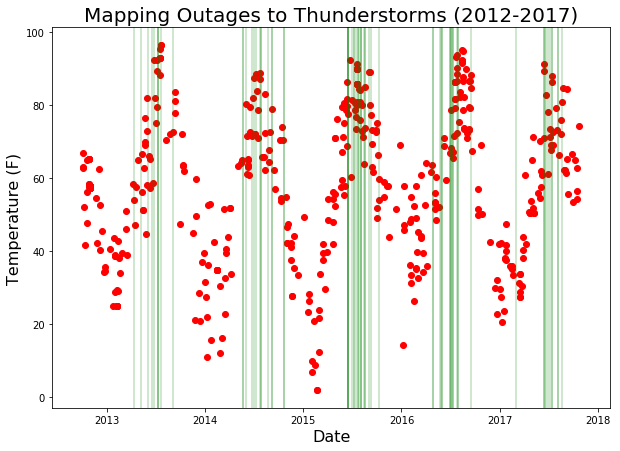

In [46]:
# Mapping Outages to Thunderstorms
plt.figure(figsize=(10, 7))
plt.scatter(outages.index, outages['temperature_f'], c ='r')
vlines = df[df['thunderstorm'] == 1].index
for line in vlines:
    plt.axvline(line, color = 'green', alpha = .25)
    
plt.xlabel('Date', fontsize=16)
plt.ylabel('Temperature (F)', fontsize=16)
plt.title('Mapping Outages to Thunderstorms (2012-2017)', fontsize=20);

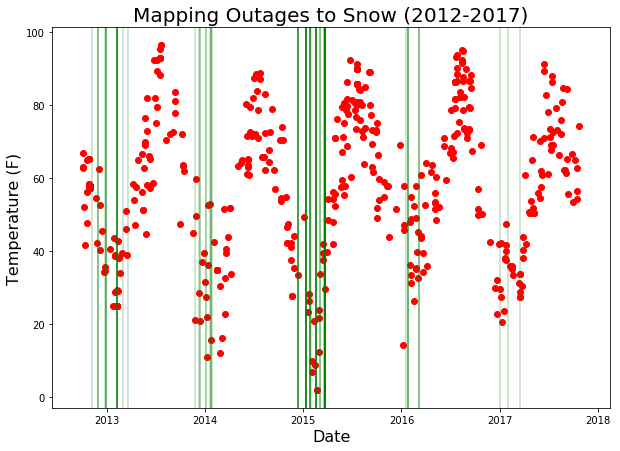

In [47]:
# Mapping Outages to Snow
plt.figure(figsize=(10, 7))
plt.scatter(outages.index, outages['temperature_f'], c ='r')
vlines = df[df['snow'] == 1].index
for line in vlines:
    plt.axvline(line, color = 'green', alpha = .25)
    
plt.xlabel('Date', fontsize=16)
plt.ylabel('Temperature (F)', fontsize=16)
plt.title('Mapping Outages to Snow (2012-2017)', fontsize=20);

#### Creating more subsets separating years to create bar plots.

In [48]:
years = ['2012', '2013', '2014', '2015', '2016', '2017']

# Creating 6 dataframes corresponding to 6 different years (2012 - 2017) consisting of only confirmed outages.
df_years = []
for year in years:
    df_years.append(outages[year])

#### Creating 6 barplots showing counts of outages per year, per month.

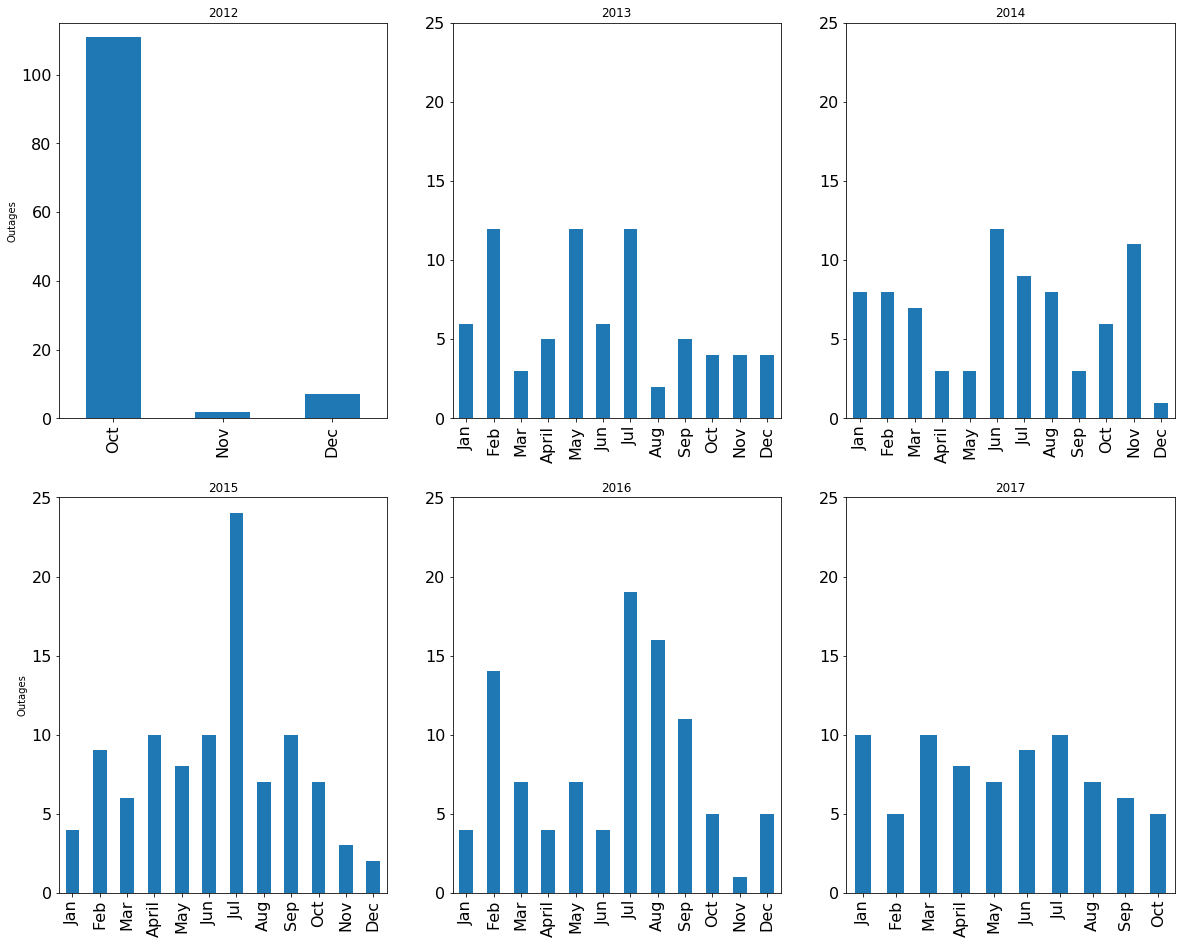

In [49]:
label = ['Oct', 'Nov', 'Dec']
months = ['Jan','Feb','Mar','April','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, ax = plt.subplots(
    nrows = 2,
    ncols = 3,
    figsize = (20, 16)


)

ax[0][0].set_xticklabels(label)
counter = 0
for i in range(3):

    df_years[i].groupby(df_years[i].index.month).count()['outage'].plot(kind = 'bar',
                                                                        ylim = (0, 25),
                                                                        ax = ax[0][counter],
                                                                        fontsize = 16,
                                                                        title = str(df_years[i].index.year.value_counts().index).replace('Int64Index([','').replace("], dtype='int64')", ""))

    counter += 1

df_years[0].groupby(df_years[0].index.month).count()['outage'].plot(
                                                                    kind = 'bar',
                                                                    ylim = (0, 115),
                                                                    ax = ax[0][0],
                                                                    fontsize = 16,
                                                                    title = str(df_years[0].index.year.value_counts().index).replace('Int64Index([','').replace("], dtype='int64')", ""))
    
counter = 0
for i in range(3,6): 
    df_years[i].groupby(df_years[i].index.month).count()['outage'].plot(kind = 'bar',
                                                                        ylim = (0, 25),
                                                                        ax = ax[1][counter],
                                                                        fontsize = 16,
                                                                        title = str(df_years[i].index.year.value_counts().index).replace('Int64Index([','').replace("], dtype='int64')", ""))
    counter += 1
    
ax[0][0].set_xticklabels(label)
ax[0][0].set(xlabel ='')
ax[0][0].set(ylabel = 'Outages')

for x in range(1,3):
    ax[0][x].set_xticklabels(months)
    ax[0][x].set_xlabel('')

    
for x in range(0,3):
    ax[1][x].set_xticklabels(months)
    ax[1][x].set_xlabel('')
    ax[1][0].set_ylabel('Outages')